Importing  libraries

In [1]:
import pandas as pd


In [2]:
# Load the dataset
df = pd.read_csv('Emotions_training.csv')

In [3]:
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


Exploratory Data Analysis (EDA)

In [4]:
# Checking for missing values
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [5]:
# Distribution of the label classes
label_counts = df['label'].value_counts().sort_index()
print(label_counts)

label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


C:\Users\masne\AppData\Local\Temp\ipykernel_5408\2715407310.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


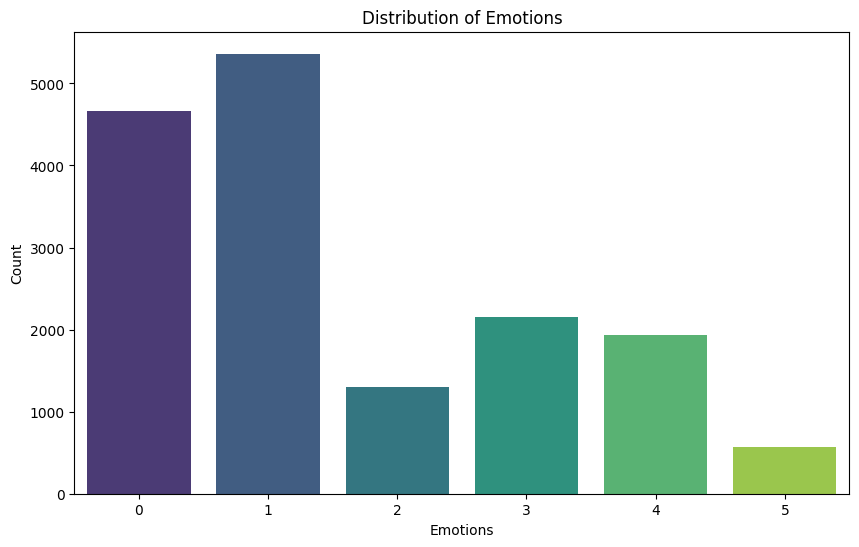

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

Data Preprocessing

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

In [11]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\masne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Stemming and lemmatization
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Join the preprocessed words back into a single string
    preprocessed_text = ' '.join(lemmatized_words)
    
    return preprocessed_text

In [13]:
# Apply preprocessing to the 'text' column 
df['text'] = df['text'].apply(preprocess_text)

In [14]:
# Display the cleaned content
print(df[['text', 'text']].head())

                                                text  \
0                                  didnt feel humili   
1  go feel hopeless damn hope around someon care ...   
2               im grab minut post feel greedi wrong   
3     ever feel nostalg fireplac know still properti   
4                                       feel grouchi   

                                                text  
0                                  didnt feel humili  
1  go feel hopeless damn hope around someon care ...  
2               im grab minut post feel greedi wrong  
3     ever feel nostalg fireplac know still properti  
4                                       feel grouchi  


Feature Engineering

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into 80% training+validation and 20% test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Split the training+validation data into 70% training and 30% validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shapes of the transformed datasets
print(f'Training data shape: {X_train_tfidf.shape}')
print(f'Validation data shape: {X_val_tfidf.shape}')
print(f'Test data shape: {X_test_tfidf.shape}')

Training data shape: (11200, 8594)
Validation data shape: (1600, 8594)
Test data shape: (3200, 8594)


Model Building

Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tfidf, y_train)
y_pred_log_reg = logreg.predict(X_test_tfidf)

# Evaluate the model
y_train_pred = logreg.predict(X_train_tfidf)
y_test_pred = logreg.predict(X_test_tfidf)

C:\Users\masne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
print("Logistic Regression - Initial Model")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))


Logistic Regression - Initial Model
Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3266
           1       0.89      0.97      0.93      3754
           2       0.93      0.73      0.82       913
           3       0.95      0.89      0.92      1511
           4       0.95      0.89      0.92      1356
           5       0.94      0.68      0.79       400

    accuracy                           0.92     11200
   macro avg       0.93      0.86      0.89     11200
weighted avg       0.92      0.92      0.92     11200



In [19]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       933
           1       0.78      0.93      0.85      1072
           2       0.81      0.48      0.60       261
           3       0.88      0.77      0.82       432
           4       0.84      0.75      0.80       387
           5       0.85      0.40      0.54       115

    accuracy                           0.82      3200
   macro avg       0.84      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200



In [27]:
from sklearn.metrics import accuracy_score
# Accuracy of Logistic Regression
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Accuracy: 0.8246875


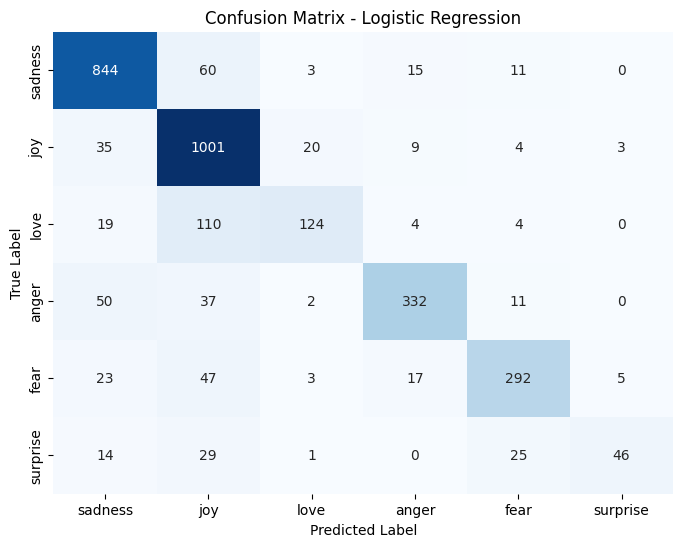

In [20]:
# Mapping the label names to their corresponding numeric values
label_mapping = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df['label'] = df['label'].map(label_mapping)


# Plot Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_random_forest = rf.predict(X_test_tfidf) 

# Evaluate the model
y_train_pred_rf = rf.predict(X_train_tfidf)
y_test_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest - Initial Model")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred_rf))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf))


Random Forest - Initial Model
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3266
           1       1.00      1.00      1.00      3754
           2       1.00      0.99      1.00       913
           3       1.00      1.00      1.00      1511
           4       1.00      1.00      1.00      1356
           5       1.00      1.00      1.00       400

    accuracy                           1.00     11200
   macro avg       1.00      1.00      1.00     11200
weighted avg       1.00      1.00      1.00     11200

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       933
           1       0.85      0.89      0.87      1072
           2       0.76      0.64      0.69       261
           3       0.86      0.82      0.84       432
           4       0.81      0.84      0.83       387
           5       0.71      0.77      0.7

In [30]:
from sklearn.metrics import accuracy_score
# Accuracy of Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_random_forest)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8509375


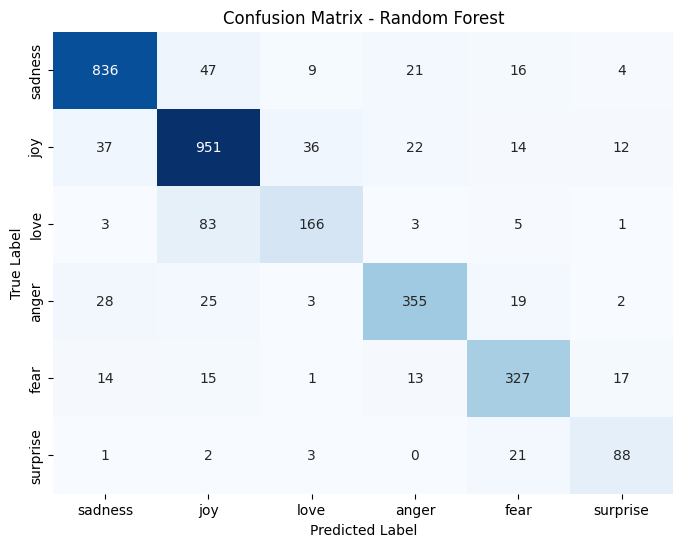

In [26]:
# Mapping the label names to their corresponding numeric values
label_mapping = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df['label'] = df['label'].map(label_mapping)

# Plot Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Support Vector Machine (SVM)

In [31]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Predictions on training set
y_train_pred_svm = svm_model.predict(X_train_tfidf)

# Predictions on test set
y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Classification report for training set
print("SVM - Training Set Classification Report:")
print(classification_report(y_train, y_train_pred_svm))

# Classification report for test set
print("SVM - Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_svm))


SVM - Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3266
           1       0.98      0.99      0.99      3754
           2       0.99      0.94      0.96       913
           3       0.99      0.99      0.99      1511
           4       0.99      0.99      0.99      1356
           5       0.99      0.97      0.98       400

    accuracy                           0.99     11200
   macro avg       0.99      0.98      0.98     11200
weighted avg       0.99      0.99      0.99     11200

SVM - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       933
           1       0.76      0.94      0.84      1072
           2       0.81      0.43      0.56       261
           3       0.89      0.78      0.83       432
           4       0.84      0.75      0.79       387
           5       0.88      0.45      0.60       11

In [32]:
# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine (SVM) Accuracy:", accuracy_svm)

Support Vector Machine (SVM) Accuracy: 0.821875


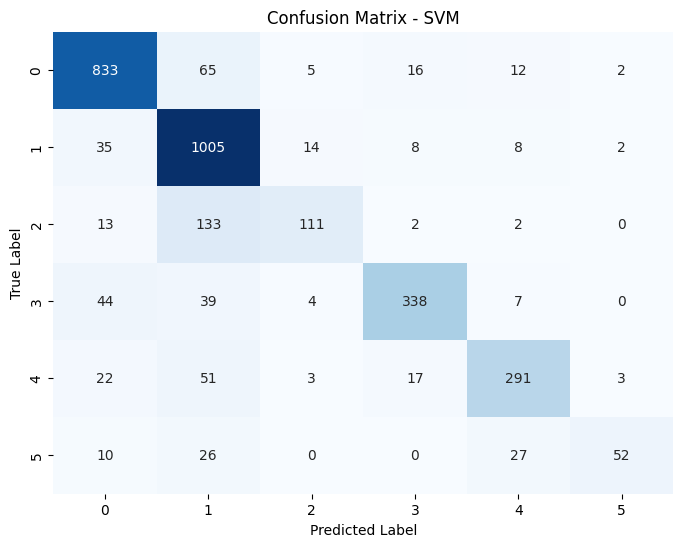

In [23]:
# Plot Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Comparing the model

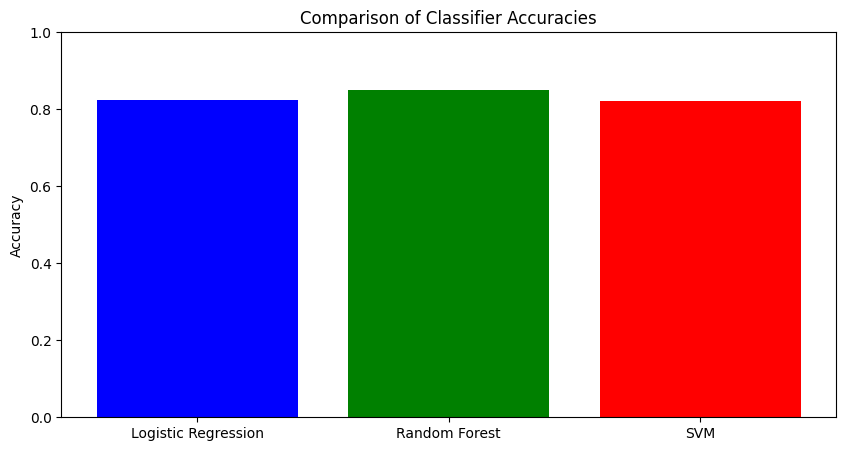

In [33]:
# Accuracy scores
accuracies = [accuracy_log_reg,  accuracy_rf, accuracy_svm]
classifiers = ['Logistic Regression', 'Random Forest', 'SVM']

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.show()

Conclusion

In this analysis, I have compared the performance of three popular machine learning classifiers: Logistic Regression, Random Forest, and Support Vector Machine (SVM),. After training each model and evaluating their accuracy on a test set, the following results were observed:

Logistic Regression: Achieved an accuracy of 82.46%

Random Forest: Achieved an accuracy of 85.09%

Support Vector Machine (SVM): Achieved an accuracy of 82.18%


Among the three models, the Random Forest classifier showed the highest accuracy. This suggests that Random Forest is particularly effective for this classification task, likely due to its ability to handle complex interactions between features and reduce overfitting through ensemble learning.